In [2]:
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns

## Helper Methods

In [3]:
colormap = plt.cm.RdBu_r

def has_index(info_list, index):
    try:
        item = info_list[index]
        return item
    except IndexError:
        return False

def get_date(value):
    date_data = str(value)[-6:]
    base_year = date_data[:2]
    prefix = '20' if int(base_year) < 18 else '19'
    year = prefix + base_year
    return year + '-' + date_data[2:4] + '-' + date_data[4:6]

def get_time(value):
    value = str(value)
    return (value[:-2] if value[:-2] != "" else "00") + ":" + value[-2:]

def get_macintosh_class(value):
    value_list = str(value).split(' ')
    if has_index(value_list, 1) is not False:
        expected_mcintosh_class = str(value_list[1])
        if re.match(r"^[A-Z]{2,3}$", expected_mcintosh_class):
            return expected_mcintosh_class
        return float('nan')
    return float('nan')

def get_spot_noaa(value):
    value_list = str(value).split(' ')
    if has_index(value_list, 1) is not False:
        return value_list[0]
    return float('nan')

def plot_decision_boundary(clf, x, y):
    feature_names = x.columns
    x, y = x.values, y.values
    x_min, x_max = x[:,0].min(), x[:,0].max()
    y_min, y_max = x[:,1].min(), x[:,1].max()
    step = 0.02
    xx, yy = np.meshgrid(
    np.arange(x_min, x_max, step),
    np.arange(y_min, y_max, step)
    )
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.figure(figsize=(12,8))
    plt.contourf(xx, yy, z, cmap=colormap, alpha=0.25)
    plt.contour(xx, yy, z, colors='k', linewidths=0.7)
    plt.scatter(x[:,0], x[:,1], c=y, edgecolors='k')
    plt.title("Tree's Decision Boundaries")
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])



# Dataset Preprocessing

### Reading Sunspots Dataset

In [4]:
spots = pd.read_fwf("datasets/spots1981-2017.txt", header=None)
spots.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,11811201,21,N13W46 BG,NaN,NaN,3478 EKI,32.0,12.0,600.0,811127.5,811127.5,938,4LEAR
1,11811201,115,N13W46,NaN,NaN,3478 EHI,16.0,11.0,530.0,811127.6,811127.5,205,2MANI
2,11811201,210,N12W47 BG,NaN,NaN,3478 EHO,22.0,14.0,710.0,811127.5,811127.5,626,2PALE
3,11811201,1355,N15W56 BG,NaN,NaN,3478 EHI,31.0,13.0,670.0,811127.3,811127.5,468,2RAMY
4,11811201,1535,N13W55 BG,NaN,NaN,3478 EHI,17.0,13.0,430.0,811127.5,811127.5,624,2HOLL


### Reading Solar Flares Dataset

In [5]:
flares = pd.read_fwf("datasets/flares1981-2017.txt", header=None)
flares.head()

,0,1,2,3,4,5,6,7,8,9
0,31777810102,441,446,0444,NaN,C,18.0,GOES,NaN,NaN
1,31777810102,955,1004,1000,NaN,C,18.0,GOES,NaN,NaN
2,31777810103,1025,1036,1030,NaN,C,51.0,GOES,NaN,NaN
3,31777810103,1549,1558,1553,NaN,C,22.0,GOES,2857.0,NaN
4,31777810103,1837,1845,1842,NaN,C,22.0,GOES,NaN,NaN


### Labeling flares & dropping unwanted features

In [6]:
flares.drop(axis=1, labels=[4,7,9], inplace=True)
flares.columns = ['Date', 'Start Time',  'End Time', 'Peak Time', 'X-ray Class', 'Flare Magnitude', 'NOAA']
flares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71984 entries, 0 to 71983
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             71984 non-null  int64  
 1   Start Time       71984 non-null  int64  
 2   End Time         71984 non-null  int64  
 3   Peak Time        71916 non-null  object 
 4   X-ray Class      71957 non-null  object 
 5   Flare Magnitude  71954 non-null  float64
 6   NOAA             38704 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.8+ MB


### Labeling sun spots & dropping unwanted features

In [7]:
spots.drop(axis=1, labels=[2,3,4,7,8,9,10,11,12], inplace=True)
spots.columns = ['Date', 'Time', 'McIntosh & NOAA', 'Number of Spots']
flares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71984 entries, 0 to 71983
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             71984 non-null  int64  
 1   Start Time       71984 non-null  int64  
 2   End Time         71984 non-null  int64  
 3   Peak Time        71916 non-null  object 
 4   X-ray Class      71957 non-null  object 
 5   Flare Magnitude  71954 non-null  float64
 6   NOAA             38704 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.8+ MB


### Remove record with bad time from solar flares

In [8]:
rows_with_bad_time = flares.loc[(flares['Start Time'] > 2359) | (flares['End Time'] > 2359)]
flares.drop(rows_with_bad_time.index, inplace=True)
flares.dropna(inplace=True)
flares.reset_index(inplace=True)
flares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38313 entries, 0 to 38312
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            38313 non-null  int64  
 1   Date             38313 non-null  int64  
 2   Start Time       38313 non-null  int64  
 3   End Time         38313 non-null  int64  
 4   Peak Time        38313 non-null  object 
 5   X-ray Class      38313 non-null  object 
 6   Flare Magnitude  38313 non-null  float64
 7   NOAA             38313 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 2.3+ MB


### Reformat solar flares date and time

In [9]:
flares['Date'] = flares['Date'].apply(get_date)
flares['Start Time'] = flares['Start Time'].apply(get_time)
flares['End Time'] = flares['End Time'].apply(get_time)
flares['Peak Time'] = flares['Peak Time'].apply(get_time)
flares.drop(axis=1, labels=['index'], inplace=True)
flares.shape

(38313, 7)

### Inspect and remove bad time from solar flares

In [10]:
indexNames = flares.loc[flares['Peak Time'] == '//://'].index
flares.drop(indexNames , inplace=True)
indexNames = flares.loc[flares['Start Time'] == '//://'].index
flares.drop(indexNames , inplace=True)
indexNames = flares.loc[flares['End Time'] == '//://'].index
flares.drop(indexNames , inplace=True)
flares.shape

(38312, 7)

### Modifying solar flares features

In [11]:
flares['Start Time'] = flares['Date'].str.cat(flares['Start Time'], sep=' ')
flares['End Time'] = flares['Date'].str.cat(flares['End Time'], sep=' ')
flares['Peak Time'] = flares['Date'].str.cat(flares['Peak Time'], sep=' ')
flares['Start Time'] = pd.to_datetime(flares['Start Time'])
flares['End Time'] =  pd.to_datetime(flares['End Time'])
flares['Peak Time'] =  pd.to_datetime(flares['Peak Time'])
flares['Flare Duration'] = (flares['End Time'] - flares["Start Time"]).dt.total_seconds() / 60
flares['Date'] = pd.to_datetime(flares['Date'])
flares['Year'] = flares['Date'].dt.year
flares['NOAA'] = flares['NOAA'].astype(np.int64).astype(str)
flares.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38312 entries, 0 to 38312
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             38312 non-null  datetime64[ns]
 1   Start Time       38312 non-null  datetime64[ns]
 2   End Time         38312 non-null  datetime64[ns]
 3   Peak Time        38312 non-null  datetime64[ns]
 4   X-ray Class      38312 non-null  object        
 5   Flare Magnitude  38312 non-null  float64       
 6   NOAA             38312 non-null  object        
 7   Flare Duration   38312 non-null  float64       
 8   Year             38312 non-null  int64         
dtypes: datetime64[ns](4), float64(2), int64(1), object(2)
memory usage: 2.9+ MB


### Remove sunspots record with bad time & format McIntosh feature

In [12]:
rows_with_bad_time = spots.loc[spots['Time'] > 2359]
spots['McIntosh Class'] = spots['McIntosh & NOAA'].apply(get_macintosh_class)
spots['NOAA'] = spots['McIntosh & NOAA'].apply(get_spot_noaa).astype(str)
spots.drop('McIntosh & NOAA', axis=1, inplace=True)
spots.drop(rows_with_bad_time.index, inplace=True)

# Further cleaning
spots['Zurich Class'] = spots['McIntosh Class'].apply(lambda x: str(x)[:1])
spots['Penumbra Class'] = spots['McIntosh Class'].apply(lambda x: str(x)[1:2])
spots['Compactness Class'] = spots['McIntosh Class'].apply(lambda x: str(x)[2:3] if len(str(x)) > 2 else float('nan'))
spots.dropna(inplace=True)
spots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192157 entries, 0 to 271882
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date               192157 non-null  object 
 1   Time               192157 non-null  int64  
 2   Number of Spots    192157 non-null  float64
 3   McIntosh Class     192157 non-null  object 
 4   NOAA               192157 non-null  object 
 5   Zurich Class       192157 non-null  object 
 6   Penumbra Class     192157 non-null  object 
 7   Compactness Class  192157 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 13.2+ MB


### Modify Sunspots features

In [13]:
spots['Number of Spots'] = spots['Number of Spots'].apply(int)
spots['Date'] = spots['Date'].apply(get_date)
spots['Time'] = spots['Time'].apply(get_time)
spots['DateTime'] = spots['Date'].str.cat(spots['Time'], sep=' ')
spots['DateTime'] = pd.to_datetime(spots['DateTime'])
spots['Date'] = pd.to_datetime(spots['Date'])
spots['Year'] = spots['Date'].dt.year
spots['Zurich Class'] = spots['Zurich Class'].apply(str)
spots['Penumbra Class'] = spots['Penumbra Class'].apply(str)
spots['Compactness Class'] = spots['Compactness Class'].apply(str)
spots.sort_values(by=['DateTime'], ascending=True, inplace=True)
spots.head(100)

,Date,Time,Number of Spots,McIntosh Class,NOAA,Zurich Class,Penumbra Class,Compactness Class,DateTime,Year
0,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981
79,1981-12-01,00:21,8,CRO,3481,C,R,O,1981-12-01 00:21:00,1981
72,1981-12-01,00:21,5,BXO,3488,B,X,O,1981-12-01 00:21:00,1981
140,1981-12-01,00:21,6,BXO,3486,B,X,O,1981-12-01 00:21:00,1981
167,1981-12-01,00:21,9,DSO,3485,D,S,O,1981-12-01 00:21:00,1981
...,...,...,...,...,...,...,...,...,...,...
304,1981-12-04,16:20,9,DSI,3492,D,S,I,1981-12-04 16:20:00,1981
362,1981-12-04,16:20,6,DSI,3496,D,S,I,1981-12-04 16:20:00,1981
251,1981-12-04,16:20,1,HRX,3490,H,R,X,1981-12-04 16:20:00,1981
178,1981-12-04,16:20,7,DSO,3485,D,S,O,1981-12-04 16:20:00,1981


In [14]:
flares.shape

(38312, 9)

In [15]:
spots.shape

(192157, 10)

## Merge sunspots dataset to flares and analyse

In [16]:
sunspot_and_solar_flares = pd.merge(spots, flares, on='NOAA', how='inner')
sunspot_and_solar_flares.shape

(1303132, 18)

In [17]:
sunspot_and_solar_flares.head()

,Date_x,Time,Number of Spots,McIntosh Class,NOAA,Zurich Class,Penumbra Class,Compactness Class,DateTime,Year_x,Date_y,Start Time,End Time,Peak Time,X-ray Class,Flare Magnitude,Flare Duration,Year_y
0,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981,1981-11-25,1981-11-25 23:19:00,1981-11-25 23:59:00,1981-11-25 23:28:00,C,52.0,40.0,1981
1,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981,1981-11-26,1981-11-26 16:15:00,1981-11-26 17:14:00,1981-11-26 16:21:00,M,20.0,59.0,1981
2,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981,1981-11-27,1981-11-27 02:22:00,1981-11-27 02:27:00,1981-11-27 02:25:00,C,22.0,5.0,1981
3,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981,1981-11-27,1981-11-27 04:28:00,1981-11-27 04:42:00,1981-11-27 04:32:00,C,25.0,14.0,1981
4,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981,1981-11-27,1981-11-27 13:51:00,1981-11-27 14:22:00,1981-11-27 14:01:00,C,19.0,31.0,1981


### Dropping Insignificant

In [18]:
sunspot_and_solar_flares = sunspot_and_solar_flares[~sunspot_and_solar_flares['X-ray Class'].isin(['A', 'B', 'C'])]
# sunspot_and_solar_flares.shape
sunspot_and_solar_flares.head()

,Date_x,Time,Number of Spots,McIntosh Class,NOAA,Zurich Class,Penumbra Class,Compactness Class,DateTime,Year_x,Date_y,Start Time,End Time,Peak Time,X-ray Class,Flare Magnitude,Flare Duration,Year_y
1,1981-12-01,00:21,32,EKI,3478,E,K,I,1981-12-01 00:21:00,1981,1981-11-26,1981-11-26 16:15:00,1981-11-26 17:14:00,1981-11-26 16:21:00,M,20.0,59.0,1981
17,1981-12-01,1:15,16,EHI,3478,E,H,I,1981-12-01 01:15:00,1981,1981-11-26,1981-11-26 16:15:00,1981-11-26 17:14:00,1981-11-26 16:21:00,M,20.0,59.0,1981
33,1981-12-01,2:10,22,EHO,3478,E,H,O,1981-12-01 02:10:00,1981,1981-11-26,1981-11-26 16:15:00,1981-11-26 17:14:00,1981-11-26 16:21:00,M,20.0,59.0,1981
49,1981-12-01,13:55,31,EHI,3478,E,H,I,1981-12-01 13:55:00,1981,1981-11-26,1981-11-26 16:15:00,1981-11-26 17:14:00,1981-11-26 16:21:00,M,20.0,59.0,1981
65,1981-12-01,15:35,17,EHI,3478,E,H,I,1981-12-01 15:35:00,1981,1981-11-26,1981-11-26 16:15:00,1981-11-26 17:14:00,1981-11-26 16:21:00,M,20.0,59.0,1981


### Further preparation of combined dataset for model

In [19]:
sunspot_and_solar_flares.drop(['NOAA', 'Time', 'Date_x', 'Date_y', 'Year_x', 'Year_y', 'DateTime', 'Start Time', 'End Time', 'Peak Time'], axis=1, inplace=True)
# sunspot_and_solar_flares['Start Time'] = (sunspot_and_solar_flares['Start Time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
# sunspot_and_solar_flares['Peak Time'] = (sunspot_and_solar_flares['Peak Time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
# sunspot_and_solar_flares['End Time'] = (sunspot_and_solar_flares['End Time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
# sunspot_and_solar_flares['DateTime'] = (sunspot_and_solar_flares['DateTime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
sunspot_and_solar_flares.dtypes

Number of Spots        int64
McIntosh Class        object
Zurich Class          object
Penumbra Class        object
Compactness Class     object
X-ray Class           object
Flare Magnitude      float64
Flare Duration       float64
dtype: object

In [20]:
sunspot_and_solar_flares.describe()

,Number of Spots,Flare Magnitude,Flare Duration
count,195859.000000,195859.000000,195859.000000
mean,25.173232,24.410806,42.687352
std,21.640125,17.953854,111.607395
min,0.000000,0.000000,-1431.000000
25%,8.000000,12.000000,18.000000
50%,19.000000,18.000000,35.000000
75%,36.000000,29.000000,64.000000
max,99.000000,99.000000,464.000000


### Encoding Labels

In [21]:
le = LabelEncoder()
sunspot_and_solar_flares['Zurich Class'] = le.fit_transform(sunspot_and_solar_flares['Zurich Class'])
sunspot_and_solar_flares['Penumbra Class'] = le.fit_transform(sunspot_and_solar_flares['Penumbra Class'])
sunspot_and_solar_flares['Compactness Class'] = le.fit_transform(sunspot_and_solar_flares['Compactness Class'])
sunspot_and_solar_flares['McIntosh Class'] = le.fit_transform(sunspot_and_solar_flares['McIntosh Class'])
sunspot_and_solar_flares['X-ray Class'] = le.fit_transform(sunspot_and_solar_flares['X-ray Class'])

In [22]:
# sunspot_and_solar_flares.head(100)
sunspot_and_solar_flares.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195859 entries, 1 to 1301190
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Number of Spots    195859 non-null  int64  
 1   McIntosh Class     195859 non-null  int64  
 2   Zurich Class       195859 non-null  int64  
 3   Penumbra Class     195859 non-null  int64  
 4   Compactness Class  195859 non-null  int64  
 5   X-ray Class        195859 non-null  int64  
 6   Flare Magnitude    195859 non-null  float64
 7   Flare Duration     195859 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 13.4 MB


### Visualising relationship of features of merged dataset

In [23]:
# Correlation matrix to plot heatmap
corr = sunspot_and_solar_flares.corr()
corr

,Number of Spots,McIntosh Class,Zurich Class,Penumbra Class,Compactness Class,X-ray Class,Flare Magnitude,Flare Duration
Number of Spots,1.000000,0.449509,0.459315,-0.073419,-0.524528,0.024598,0.022558,0.029418
McIntosh Class,0.449509,1.000000,0.979483,-0.010603,-0.346941,0.028555,0.022477,-0.010923
Zurich Class,0.459315,0.979483,1.000000,-0.199445,-0.370978,0.026651,0.024999,-0.009475
Penumbra Class,-0.073419,-0.010603,-0.199445,1.000000,0.083771,0.009389,-0.011991,-0.007139
Compactness Class,-0.524528,-0.346941,-0.370978,0.083771,1.000000,-0.063966,-0.045910,-0.023252
X-ray Class,0.024598,0.028555,0.026651,0.009389,-0.063966,1.000000,-0.019589,0.107003
Flare Magnitude,0.022558,0.022477,0.024999,-0.011991,-0.045910,-0.019589,1.000000,0.040299
Flare Duration,0.029418,-0.010923,-0.009475,-0.007139,-0.023252,0.107003,0.040299,1.000000


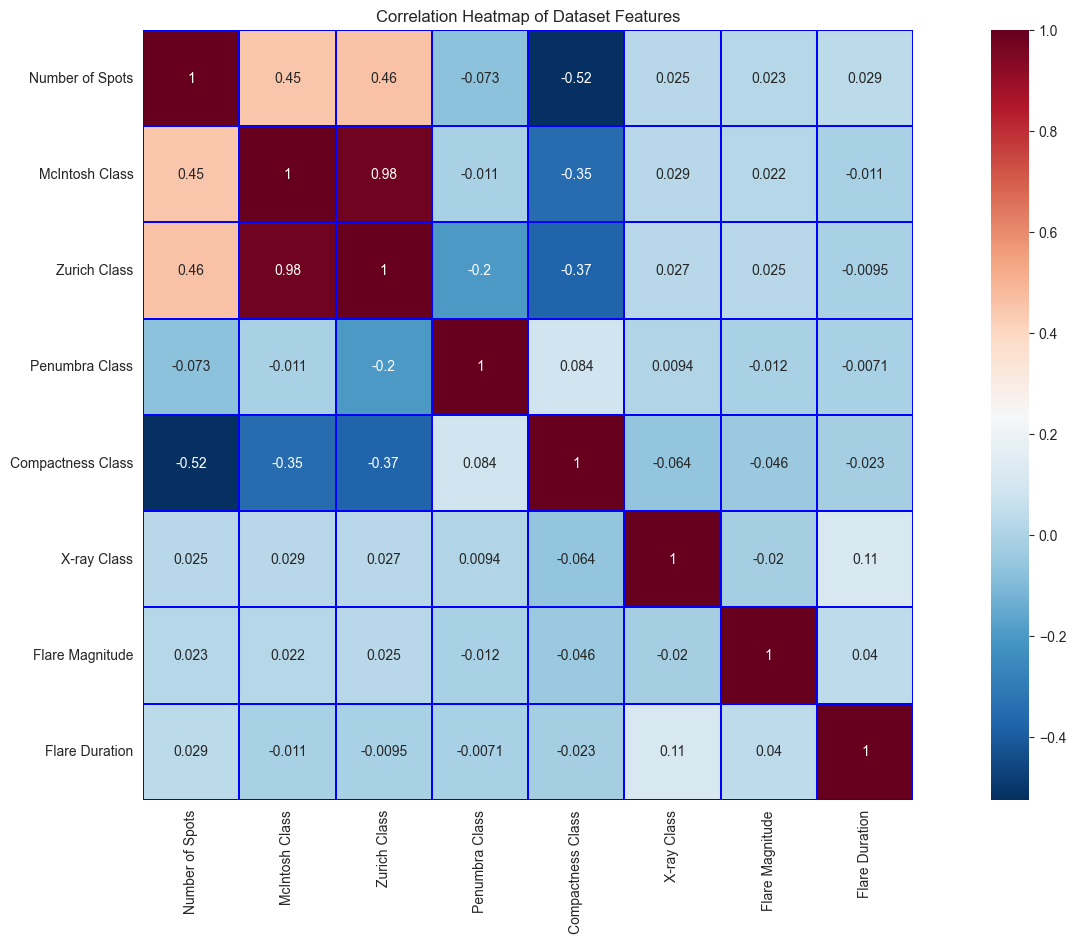

In [24]:
#heat map plot
plt.gcf().set_size_inches((20,10))
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
            square=True, linewidths=0.15, cmap=colormap, linecolor='blue', annot=True)
plt.title('Correlation Heatmap of Dataset Features')
plt.show()

### Splitting dataset into training and testing sets for X-ray Class Prediction

In [25]:
x = sunspot_and_solar_flares.drop('X-ray Class', axis=1)
y = sunspot_and_solar_flares['X-ray Class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=7)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (176273, 7)
y_train shape: (176273,)
x_test shape: (19586, 7)
y_test shape: (19586,)


### Class balance check & Fix

In [26]:
y_train.value_counts()

0    162184
1     14089
Name: X-ray Class, dtype: int64

In [27]:
smote = SMOTE(sampling_strategy=0.5)
rus = RandomUnderSampler(sampling_strategy=1)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
x_train_resampled, y_train_resampled= rus.fit_resample(x_train_resampled, y_train_resampled)
y_train_resampled.value_counts()

0    81092
1    81092
Name: X-ray Class, dtype: int64

### Training, evaluation and cross validation of a model using logistic regression

In [28]:
# Training
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000, tol=1e-3)
lr_model.fit(x_train, y_train)

# Evaluating
lr_y_pred = lr_model.predict(x_test)
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_precision = precision_score(y_test, lr_y_pred, average='macro', zero_division=0)
lr_recall = recall_score(y_test, lr_y_pred, average='macro')
lr_f1 = f1_score(y_test, lr_y_pred, average='macro')

print('Initial Accuracy:', lr_accuracy)
print('Initial Precision:', lr_precision)
print('Initial Recall:', lr_recall)
print('Initial F1 Score:', lr_f1)

# Cross validation
rs = ShuffleSplit(n_splits=10, test_size=0.3)

accuracy_scorer = make_scorer(accuracy_score)
precision_scorer = make_scorer(precision_score, zero_division=0)
recall_scorer = make_scorer(recall_score)
f1_scorer = make_scorer(f1_score)

accuracy_results = cross_validate(lr_model, x, y, cv=rs, scoring=accuracy_scorer)
precision_results = cross_validate(lr_model, x, y, cv=rs, scoring=precision_scorer)
recall_results = cross_validate(lr_model, x, y, cv=rs, scoring=recall_scorer)
f1_results = cross_validate(lr_model, x, y, cv=rs, scoring=f1_scorer)

accuracy_scores = pd.Series(accuracy_results['test_score'])
precision_scores = pd.Series(precision_results['test_score'])
recall_scores = pd.Series(recall_results['test_score'])
f1_scores = pd.Series(f1_results['test_score'])

print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
print('Average Accuracy Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(accuracy_scores.mean(),accuracy_scores.quantile(.05),accuracy_scores.quantile(.95),))
print("Precision: %0.2f (+/- %0.2f)" % (precision_scores.mean(), precision_scores.std() * 2))
print('Average Precision Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(precision_scores.mean(),precision_scores.quantile(.05),precision_scores.quantile(.95),))
print("Recall: %0.2f (+/- %0.2f)" % (recall_scores.mean(), recall_scores.std() * 2))
print('Average Recall Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(recall_scores.mean(),recall_scores.quantile(.05),recall_scores.quantile(.95),))
print("F1: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))

print('Average F1 Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(f1_scores.mean(),f1_scores.quantile(.05),f1_scores.quantile(.95),))

Initial Accuracy: 0.9220361482691719
Initial Precision: 0.6968500762373915
Initial Recall: 0.5136823833432235
Initial F1 Score: 0.5080813352253378
Accuracy: 0.92 (+/- 0.00)
Average Accuracy Score: 0.92 [5th percentile: 0.919 & 95th percentile:0.921]
Precision: 0.49 (+/- 0.07)
Average Precision Score: 0.486 [5th percentile: 0.433 & 95th percentile:0.523]
Recall: 0.03 (+/- 0.00)
Average Recall Score: 0.0303 [5th percentile: 0.0294 & 95th percentile:0.0311]
F1: 0.06 (+/- 0.01)
Average F1 Score: 0.0575 [5th percentile: 0.0531 & 95th percentile:0.0612]


### Logistic regression performance metrics distributions plots

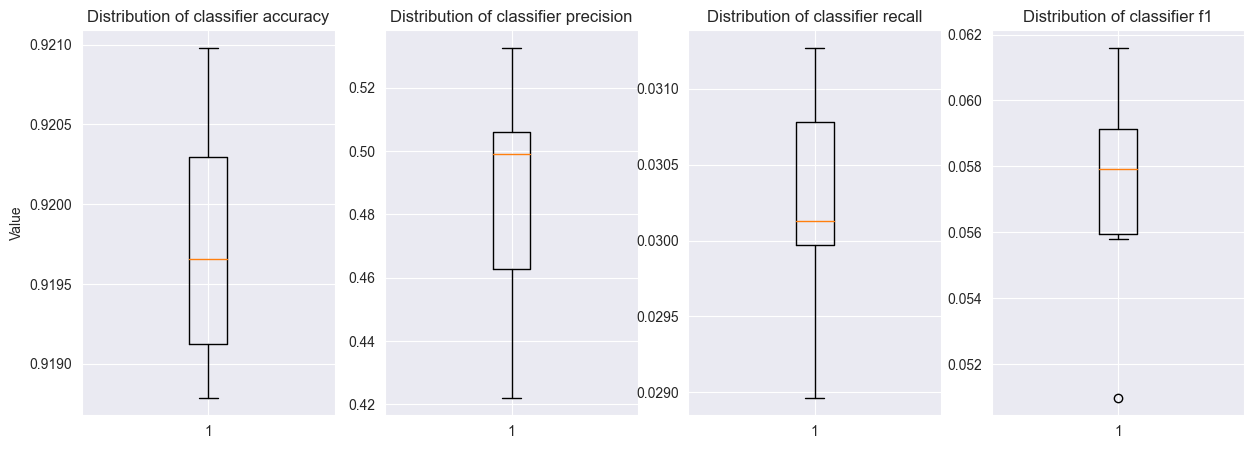

In [29]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Create a box plot for metrics a
axs[0].boxplot(accuracy_scores)
axs[1].boxplot(precision_scores)
axs[2].boxplot(recall_scores)
axs[3].boxplot(f1_scores)

# Set the title and axis labels for each subplot
axs[0].set_title('Distribution of classifier accuracy')
axs[1].set_title('Distribution of classifier precision')
axs[2].set_title('Distribution of classifier recall')
axs[3].set_title('Distribution of classifier f1')
axs[0].set_ylabel('Value')

# Show the plot
plt.show()

###  Training & evaluation of a model using Decision Tree

In [30]:
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)

# Evaluating
dt_y_pred = dt_model.predict(x_test)
dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_precision = precision_score(y_test, dt_y_pred, average='macro', zero_division=0)
dt_recall = recall_score(y_test, dt_y_pred, average='macro')
dt_f1 = f1_score(y_test, dt_y_pred, average='macro')

print('Accuracy:', dt_accuracy)
print('Precision:', dt_precision)
print('Recall:', dt_recall)
print('F1 Score:', dt_f1)

# Cross validation
rs = ShuffleSplit(n_splits=50, test_size=0.3)

accuracy_scorer = make_scorer(accuracy_score)
precision_scorer = make_scorer(precision_score, zero_division=0)
recall_scorer = make_scorer(recall_score)
f1_scorer = make_scorer(f1_score)

accuracy_results = cross_validate(dt_model, x, y, cv=rs, scoring=accuracy_scorer)
precision_results = cross_validate(dt_model, x, y, cv=rs, scoring=precision_scorer)
recall_results = cross_validate(dt_model, x, y, cv=rs, scoring=recall_scorer)
f1_results = cross_validate(dt_model, x, y, cv=rs, scoring=f1_scorer)

accuracy_scores = pd.Series(accuracy_results['test_score'])
precision_scores = pd.Series(precision_results['test_score'])
recall_scores = pd.Series(recall_results['test_score'])
f1_scores = pd.Series(f1_results['test_score'])

print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
print('Average Accuracy Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(accuracy_scores.mean(),accuracy_scores.quantile(.05),accuracy_scores.quantile(.95),))
print("Precision: %0.2f (+/- %0.2f)" % (precision_scores.mean(), precision_scores.std() * 2))
print('Average Precision Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(precision_scores.mean(),precision_scores.quantile(.05),precision_scores.quantile(.95),))
print("Recall: %0.2f (+/- %0.2f)" % (recall_scores.mean(), recall_scores.std() * 2))
print('Average Recall Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(recall_scores.mean(),recall_scores.quantile(.05),recall_scores.quantile(.95),))
print("F1: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))
print('Average F1 Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(f1_scores.mean(),f1_scores.quantile(.05),f1_scores.quantile(.95),))

Accuracy: 0.9753905851118145
Precision: 0.9181802975776572
Recall: 0.9080843829891074
F1 Score: 0.9130572061718324
Accuracy: 0.97 (+/- 0.00)
Average Accuracy Score: 0.974 [5th percentile: 0.973 & 95th percentile:0.975]
Precision: 0.84 (+/- 0.01)
Average Precision Score: 0.84 [5th percentile: 0.828 & 95th percentile:0.851]
Recall: 0.83 (+/- 0.01)
Average Recall Score: 0.827 [5th percentile: 0.817 & 95th percentile:0.836]
F1: 0.83 (+/- 0.01)
Average F1 Score: 0.833 [5th percentile: 0.827 & 95th percentile:0.84]


### Decision tree classifier performance metrics distribution plot

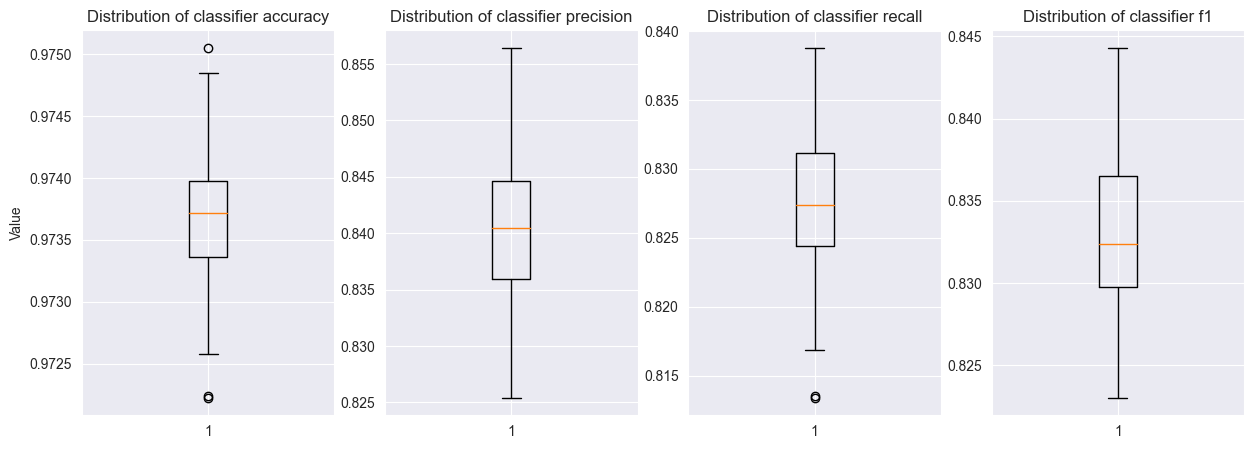

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Create a box plot for metrics a
axs[0].boxplot(accuracy_scores)
axs[1].boxplot(precision_scores)
axs[2].boxplot(recall_scores)
axs[3].boxplot(f1_scores)

# Set the title and axis labels for each subplot
axs[0].set_title('Distribution of classifier accuracy')
axs[1].set_title('Distribution of classifier precision')
axs[2].set_title('Distribution of classifier recall')
axs[3].set_title('Distribution of classifier f1')
axs[0].set_ylabel('Value')

# Show the plot
plt.show()

### Training & evaluation of a model using Random Forest

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

# Evaluating
rf_y_pred = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred, average='macro', zero_division=0)
rf_recall = recall_score(y_test, rf_y_pred, average='macro')
rf_f1 = f1_score(y_test, rf_y_pred, average='macro')

print('Accuracy:', rf_accuracy)
print('Precision:', rf_precision)
print('Recall:', rf_recall)
print('F1 Score:', rf_f1)

# Cross validation
rs = ShuffleSplit(n_splits=50, test_size=0.3)

accuracy_scorer = make_scorer(accuracy_score)
precision_scorer = make_scorer(precision_score, zero_division=0)
recall_scorer = make_scorer(recall_score)
f1_scorer = make_scorer(f1_score)

accuracy_results = cross_validate(rf_model, x, y, cv=rs, scoring=accuracy_scorer)
precision_results = cross_validate(rf_model, x, y, cv=rs, scoring=precision_scorer)
recall_results = cross_validate(rf_model, x, y, cv=rs, scoring=recall_scorer)
f1_results = cross_validate(rf_model, x, y, cv=rs, scoring=f1_scorer)

accuracy_scores = pd.Series(accuracy_results['test_score'])
precision_scores = pd.Series(precision_results['test_score'])
recall_scores = pd.Series(recall_results['test_score'])
f1_scores = pd.Series(f1_results['test_score'])

print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
print('Average Accuracy Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(accuracy_scores.mean(),accuracy_scores.quantile(.05),accuracy_scores.quantile(.95),))
print("Precision: %0.2f (+/- %0.2f)" % (precision_scores.mean(), precision_scores.std() * 2))
print('Average Precision Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(precision_scores.mean(),precision_scores.quantile(.05),precision_scores.quantile(.95),))
print("Recall: %0.2f (+/- %0.2f)" % (recall_scores.mean(), recall_scores.std() * 2))
print('Average Recall Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(recall_scores.mean(),recall_scores.quantile(.05),recall_scores.quantile(.95),))
print("F1: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))
print('Average F1 Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(f1_scores.mean(),f1_scores.quantile(.05),f1_scores.quantile(.95),))

Accuracy: 0.9655876646584295
Precision: 0.9189353538983245
Recall: 0.8250984964987818
F1 Score: 0.8649254260667442


### Random forest classifier performance metrics distribution plot

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Create a box plot for metrics a
axs[0].boxplot(accuracy_scores)
axs[1].boxplot(precision_scores)
axs[2].boxplot(recall_scores)
axs[3].boxplot(f1_scores)

# Set the title and axis labels for each subplot
axs[0].set_title('Distribution of classifier accuracy')
axs[1].set_title('Distribution of classifier precision')
axs[2].set_title('Distribution of classifier recall')
axs[3].set_title('Distribution of classifier f1')
axs[0].set_ylabel('Value')

# Show the plot
plt.show()

### Training & evaluation of a model using Support Vector Machine (SVM)

In [ ]:
################## This works fine but takes crazy amount of time to run, if your computer is really powerful enough, you can uncomment and run
##################
##################
##################
##################




# svc_model = SVC()
# svc_model.fit(x_train, y_train)
#
# # Evaluating
# svc_y_pred = svc_model.predict(x_test)
# svc_accuracy = accuracy_score(y_test, svc_y_pred)
# svc_precision = precision_score(y_test, svc_y_pred, average='macro', zero_division=0)
# svc_recall = recall_score(y_test, svc_y_pred, average='macro')
# svc_f1 = f1_score(y_test, svc_y_pred, average='macro')
#
# print('Accuracy:', svc_accuracy)
# print('Precision:', svc_precision)
# print('Recall:', svc_recall)
# print('F1 Score:', svc_f1)
#
# # Cross validation
# rs = ShuffleSplit(n_splits=100, test_size=0.3)
#
# accuracy_scorer = make_scorer(accuracy_score)
# precision_scorer = make_scorer(precision_score, zero_division=0)
# recall_scorer = make_scorer(recall_score)
# f1_scorer = make_scorer(f1_score)
#
# accuracy_results = cross_validate(svc_model, x, y, cv=rs, scoring=accuracy_scorer)
# precision_results = cross_validate(svc_model, x, y, cv=rs, scoring=precision_scorer)
# recall_results = cross_validate(svc_model, x, y, cv=rs, scoring=recall_scorer)
# f1_results = cross_validate(svc_model, x, y, cv=rs, scoring=f1_scorer)
#
# accuracy_scores = pd.Series(accuracy_results['test_score'])
# precision_scores = pd.Series(precision_results['test_score'])
# recall_scores = pd.Series(recall_results['test_score'])
# f1_scores = pd.Series(f1_results['test_score'])
#
# print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
# print('Average Accuracy Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
#       .format(accuracy_scores.mean(),accuracy_scores.quantile(.05),accuracy_scores.quantile(.95),))
# print("Precision: %0.2f (+/- %0.2f)" % (precision_scores.mean(), precision_scores.std() * 2))
# print('Average Precision Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
#       .format(precision_scores.mean(),precision_scores.quantile(.05),precision_scores.quantile(.95),))
# print("Recall: %0.2f (+/- %0.2f)" % (recall_scores.mean(), recall_scores.std() * 2))
# print('Average Recall Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
#       .format(recall_scores.mean(),recall_scores.quantile(.05),recall_scores.quantile(.95),))
# print("F1: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))
# print('Average F1 Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
#       .format(f1_scores.mean(),f1_scores.quantile(.05),f1_scores.quantile(.95),))

### Support vector machine classifier performance metrics distribution plot

In [ ]:
# fig, axs = plt.subplots(1, 4, figsize=(15, 5))
#
# # Create a box plot for metrics a
# axs[0].boxplot(accuracy_scores)
# axs[1].boxplot(precision_scores)
# axs[2].boxplot(recall_scores)
# axs[3].boxplot(f1_scores)
#
# # Set the title and axis labels for each subplot
# axs[0].set_title('Distribution of classifier accuracy')
# axs[1].set_title('Distribution of classifier precision')
# axs[2].set_title('Distribution of classifier recall')
# axs[3].set_title('Distribution of classifier f1')
# axs[0].set_ylabel('Value')
#
# # Show the plot
# plt.show()